Import The Library

In [1]:
# Import The Standard Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Library For Audio and Path
import librosa
import os

# Import Audio Classification
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Warning Filter
import warnings
warnings.filterwarnings('ignore')

Build Data Folder Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dogs_folder_path = '/content/drive/My Drive/cats_dogs_no_split/dogs'
cats_folder_path = '/content/drive/My Drive/cats_dogs_no_split/cats'

In [4]:
def load_wav (file_path):
  wav, sample_rate = librosa.load(file_path, mono=True)
  wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
  return wav

In [5]:
# Testing Plot The Wave
dog_sample = os.path.join(dogs_folder_path, 'dog_barking_40.wav')
cat_sample = os.path.join(cats_folder_path, 'cat_93.wav')

dog_wav = load_wav(dog_sample)
cat_wav = load_wav(cat_sample)

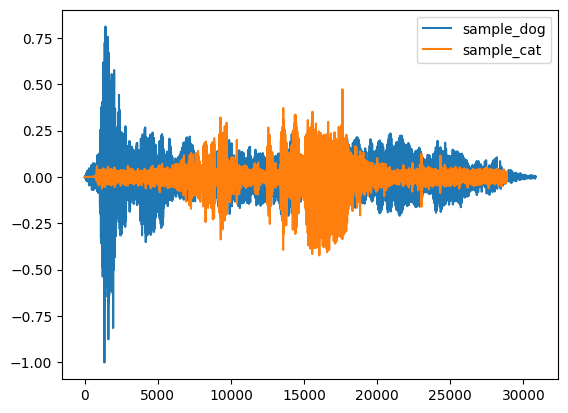

In [6]:
# Plot The Wav
plt.plot(dog_wav, label='sample_dog')
plt.plot(cat_wav, label='sample_cat')
plt.legend()
plt.show()

Path The Files Data and Add The Label

In [7]:
cats_list = tf.data.Dataset.list_files(cats_folder_path+'/*.wav')
dogs_list = tf.data.Dataset.list_files(dogs_folder_path+'/*.wav')

In [8]:
tf.data.Dataset.from_tensor_slices(tf.zeros(len(cats_list)))

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [9]:
# Adding The Label
cats = tf.data.Dataset.zip((cats_list, tf.data.Dataset.from_tensor_slices(tf.zeros(len(cats_list)))))
dogs = tf.data.Dataset.zip((dogs_list, tf.data.Dataset.from_tensor_slices(tf.ones(len(dogs_list)))))
data = cats.concatenate(dogs)

Average Length

In [10]:
length_cats, length_dogs = [], []

for file in os.listdir(cats_folder_path):
  wav = load_wav(os.path.join(cats_folder_path, file))
  length_cats.append(len(wav))

for file in os.listdir(dogs_folder_path):
  wav = load_wav(os.path.join(dogs_folder_path, file))
  length_cats.append(len(wav))

In [11]:
np.mean(np.concatenate((length_cats, length_dogs), axis=0)), np.min(np.concatenate((length_cats, length_dogs), axis=0)), np.max(np.concatenate((length_cats, length_dogs), axis=0))

(111038.1119133574, 14774.0, 287617.0)

Preprocessing Audio

In [12]:
def preprocess(file_path, label):
  wav = load_wav(file_path)
  wav = wav[:62000]
  zero_padding = tf.zeros([62000]-tf.shape(wav))
  wav = tf.concat([zero_padding, wav], axis=0)
  spectogram = tf.signal.stft(wav, frame_length=2048, frame_step=512)
  spectogram = tf.abs(spectogram)
  spectogram = np.expand_dims(spectogram, axis=2)
  return spectogram, label

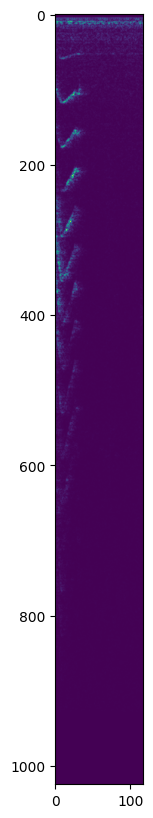

In [13]:
# Plot The Spectogram
file_path, label = cats.as_numpy_iterator().next()
file_path_decoded = file_path.decode('utf-8')
spectogram, label = preprocess(file_path_decoded, label)
plt.figure(figsize=(30,10))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

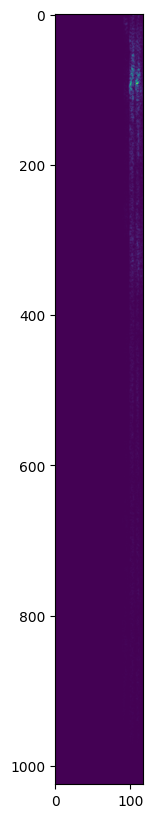

In [14]:
file_path, label = dogs.as_numpy_iterator().next()
file_path_decoded = file_path.decode('utf-8')
spectogram, label = preprocess(file_path_decoded, label)
plt.figure(figsize=(30,10))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

Train Test Split

In [15]:
x, y = [], []

for file_path, label in data.as_numpy_iterator():
    file_path_decoded = file_path.decode('utf-8')
    spectogram, label = preprocess(file_path_decoded, label)
    x.append(spectogram)
    y.append(label)

x = np.array(x)
y = np.array(y)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [17]:
x_train.shape

(193, 118, 1025, 1)

Make The Model

In [18]:
# Input Layer
input_layer = keras.layers.Input(shape=(118,1025,1))

# Convolutional Layer
conv1 = keras.layers.Conv2D(16, (3,3), activation='relu', padding='valid')(input_layer)
conv2 = keras.layers.Conv2D(16, (3,3), activation='relu', padding='valid')(conv1)

# Hidden Layer
flatten_layer = keras.layers.Flatten()(conv2)
Hidden_layer = keras.layers.Dense(128, activation='relu')(flatten_layer)

# Output Layer
output_layer = keras.layers.Dense(1, activation='sigmoid')(Hidden_layer)

# Model
model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

In [19]:
tensorboard = keras.callbacks.TensorBoard('.')
model.compile(
    optimizer = 'adam',
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118, 1025, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 116, 1023, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 114, 1021, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 1862304)           0         
                                                                 
 dense (Dense)               (None, 128)               238375040 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 238377649 (909.34 MB)
Trainable params: 2383776

In [20]:
model.fit(
    x_train,
    y_train,
    verbose=1,
    epochs=8,
    validation_data = (x_test, y_test),
    callbacks = [tensorboard]
)

Epoch 1/8
7/7 [==============================] - 14s 301ms/step - loss: 12.3747 - accuracy: 0.7098 - val_loss: 9.3108 - val_accuracy: 0.7738
Epoch 2/8
7/7 [==============================] - 1s 146ms/step - loss: 2.3501 - accuracy: 0.9016 - val_loss: 5.7987 - val_accuracy: 0.7976
Epoch 3/8
7/7 [==============================] - 1s 154ms/step - loss: 0.7152 - accuracy: 0.9378 - val_loss: 3.6914 - val_accuracy: 0.8452
Epoch 4/8
7/7 [==============================] - 1s 164ms/step - loss: 0.0043 - accuracy: 0.9948 - val_loss: 2.9241 - val_accuracy: 0.8810
Epoch 5/8
7/7 [==============================] - 1s 158ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.6393 - val_accuracy: 0.8810
Epoch 6/8
7/7 [==============================] - 1s 154ms/step - loss: 4.8501e-04 - accuracy: 1.0000 - val_loss: 2.5027 - val_accuracy: 0.8929
Epoch 7/8
7/7 [==============================] - 1s 157ms/step - loss: 4.2465e-04 - accuracy: 1.0000 - val_loss: 2.4370 - val_accuracy: 0.8810
Epoch 8/8
7/7 [==

In [21]:
prediksi = model.predict(x_test)
y_pred = []
for predik in prediksi:
  if predik > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

3/3 [==============================] - 0s 24ms/step


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        49
         1.0       0.88      0.83      0.85        35

    accuracy                           0.88        84
   macro avg       0.88      0.87      0.88        84
weighted avg       0.88      0.88      0.88        84



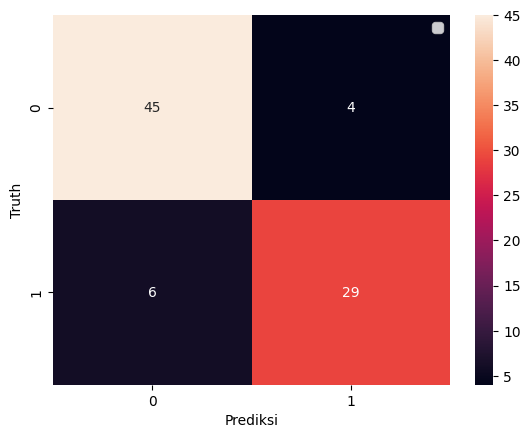

In [23]:
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, annot=True)
plt.xlabel('Prediksi')
plt.ylabel('Truth')
plt.legend()

In [24]:
model.save('Cat_and_Dog_AudioClassification.h5')

Cat Classification From Outer File

In [25]:
def load_wav_mp3 (file_name, target_sr):
  try:
    wav, sample_rate = librosa.load(file_name, sr=target_sr, mono=True)
    return wav
  except:
    return print('There is an Enror with Ur File')

In [26]:
file_path = 'Suara anak kucing lucu.mp3'

In [27]:
audio = load_wav_mp3(file_path, 16000)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(audio,audio,sequence_length=62000, sequence_stride=62000,batch_size=1)

In [28]:
# Fungsi Untuk MP 3
def preprocess_mp3 (audio, index):
  audio = audio[0]
  zero_padding = tf.zeros([62000] - tf.shape(audio), dtype=tf.float32)
  audio = tf.concat([zero_padding, audio], axis=0)
  spectogram = tf.signal.stft(audio, frame_length=2048, frame_step=512)
  spectogram = tf.abs(spectogram)
  spectogram = np.expand_dims(spectogram, axis=2)
  return spectogram

In [29]:
test_per_value = []

for audio, index in audio_slices.as_numpy_iterator():
  audio_slices = preprocess_mp3(audio, index)
  test_per_value.append(audio_slices)

test_per_value = np.array(test_per_value)

In [30]:
prediction = model.predict(test_per_value)
outside_pred = []
for pred_mp3 in prediction:
  if pred_mp3 > 0.5:
    outside_pred.append(1)
  else:
    outside_pred.append(0)

1/1 [==============================] - 0s 255ms/step


In [31]:
outside_pred

[0, 0, 0, 0, 1, 0, 1, 0]

Dog Classification from Outer File

In [44]:
file_path_dog = 'dog-barking-70772.mp3'

In [45]:
audio = load_wav_mp3(file_path_dog, 16000)
audio_slicer = tf.keras.utils.timeseries_dataset_from_array(audio, audio, sequence_length=62000, sequence_stride=62000, batch_size=1)

In [46]:
test_audio_dogs = []

for audio, index in audio_slicer.as_numpy_iterator():
  spectogram = preprocess_mp3(audio, index)
  test_audio_dogs.append(spectogram)

test_audio_dogs = np.array(test_audio_dogs)

In [47]:
pred = model.predict(test_audio_dogs)
dog_pred = []
for pred_mp3 in pred:
  if pred_mp3 > 0.5:
    dog_pred.append(1)
  else:
    dog_pred.append(0)

1/1 [==============================] - 0s 197ms/step


In [48]:
np.sum(dog_pred), dog_pred

(4, [1, 1, 1, 1])

Model Lite Converter

In [32]:
!pip install tensorflow-model-optimization

In [33]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model(model)
quantize_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
quantize_model.fit(
    x_train, y_train,
    epochs=1,
    verbose=1,
    validation_data=(x_test, y_test)
)

7/7 [==============================] - 9s 313ms/step - loss: 0.0362 - accuracy: 0.9896 - val_loss: 0.3396 - val_accuracy: 0.8929


In [34]:
quantize = tf.lite.TFLiteConverter.from_keras_model(quantize_model)
quantize.optimizations = [tf.lite.Optimize.DEFAULT]
model_quantize = quantize.convert()

with open ('cat_dogs_audio_classification.tflite', 'wb') as f:
    f.write(model_quantize)

Take The Model From Collab

In [35]:
from google.colab import files
files.download('cat_dogs_audio_classification.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# files.download('Cat_and_Dog_AudioClassification.h5')